In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load Travis' table

In [2]:
tb = pd.read_csv("All_KepStars_For_Ruth_McQuillan_Analysis_grJHK.csv")
print(np.shape(tb))

(177039, 20)


In [3]:
tb.head()

KIC            source_id       plx      plxe    g_final  g_final_err  \
0  757076  2050233807328471424  0.001524  0.000048  12.350957     0.020306   
1  757099  2050233601176543104  0.002708  0.000027  13.704047     0.020015   
2  757137  2050230543159814656  0.001753  0.000025  10.052258     0.027917   
3  757280  2050230611879323904  0.001214  0.000022  12.132906     0.020044   
4  757450  2050231848829944320  0.001199  0.000026  15.894970     0.020246   

  g_prov_final    r_final  r_final_err r_prov_final    Jmag  e_Jmag    Hmag  \
0  g_kic_fixed  11.588633     0.020419  r_kic_fixed  10.126   0.018   9.667   
1  g_kis_fixed  13.115469     0.020004  r_kis_fixed  11.656   0.018  11.193   
2  g_kic_fixed   9.099976     0.035228  r_kic_fixed   7.467   0.027   6.853   
3  g_kic_fixed  11.825413     0.020076  r_kic_fixed  10.852   0.018  10.662   
4  g_kis_fixed  15.152545     0.020081  r_kis_fixed  13.665   0.021  13.262   

   e_Hmag    Kmag  e_Kmag  [Fe/H]i n_[Fe/H]i        _RA       _DE  
0   0.019   9.559   0.017   -0.083       KIC  291.03873  36.59813  
1   0.019  11.094   0.018   -0.208       KIC  291.04306  36.59381  
2   0.018   6.722   0.017   -0.079       KIC  291.05588  36.55995  
3   0.018  10.627   0.018   -0.231       KIC  291.09540  36.56494  
4   0.025  13.118   0.029    0.229       SPE  291.13760  36.57738

Crossmatch with the McQuillan catalogue.

In [4]:
url = "https://arxiv.org/src/1402.5694v2/anc/Table_1_Periodic.txt"
mc = pd.read_csv(url)
mc.head()

KID  Teff  logg    Mass    Prot  Prot_err      Rper    LPH       w  DC  \
0   892376  3813  4.47  0.4699   1.532     0.007   7306.69  0.823  0.4503   0   
1  1026146  4261  4.57  0.6472  14.891     0.120  11742.56  1.405  0.7229   0   
2  1026474  4122  4.56  0.5914   1.569     0.006  30471.80  1.204  0.6061   0   
3  1162635  3760  4.77  0.4497  15.678     0.019  10207.47  0.978  0.5445   1   
4  1164102  4045  4.62  0.5606  31.496     0.474   5139.74  0.568  0.3939   0   

  Flag  
0  ---  
1  ---  
2  ---  
3  ---  
4  ---

In [5]:
print(np.shape(mc))

(34030, 11)


In [6]:
mctb1 = pd.merge(tb, mc, left_on="KIC", right_on="KID", how="inner")
print(np.shape(tb), np.shape(mc), np.shape(mctb1))

(177039, 20) (34030, 11) (30086, 31)


Add Teffs from Travis' catalog.

In [7]:
with fits.open("hlsp_kg-radii_kepler-gaia_multi_all_multi_v1_star-cat.fits") as data:
    tb2 = pd.DataFrame(data[1].data, dtype="float64")
    
tb_teff = pd.DataFrame(dict({"berger_teff": tb2.Teff, "berger_teff_err": tb2.Teff_err,
                             "KIC": tb2.KIC_ID}))

In [8]:
mctb = pd.merge(mctb1, tb_teff, left_on="KID", right_on="KIC", how="inner")
print(np.shape(mctb), np.shape(mctb1), np.shape(tb_teff))

(30044, 34) (30086, 31) (177911, 3)


Download Gaia catalog

In [9]:
import astropy.utils as au
from astropy.io import fits

gaia_url = "https://dl.dropboxusercontent.com/s/xo1n12fxzgzybny/kepler_dr2_1arcsec.fits?dl=0"

with fits.open(gaia_url) as data:
    gaia = pd.DataFrame(data[1].data, dtype="float64")

In [10]:
# for k in gaia.keys():
#     print(k)

Merge the Gaia catalog and the McQuillan sample and apply S/N cuts.

In [11]:
gaia_mc = pd.merge(mctb, gaia, left_on="KID", right_on="kepid", how="left")
print(np.shape(mctb), np.shape(gaia), np.shape(gaia_mc))

sn = gaia_mc.parallax.values/gaia_mc.parallax_error.values

m = (sn > 10) * (gaia_mc.parallax.values > 0) * np.isfinite(gaia_mc.parallax.values)
gaia_mc = gaia_mc.iloc[m]
print(np.shape(gaia_mc))

(30044, 34) (197090, 101) (30334, 135)
(29874, 135)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


Calculate Av

In [12]:
from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarQuery
import astropy.units as units

bayestar = BayestarQuery(max_samples=2, version='bayestar2019')

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 19.384 s
  pix_info:   0.435 s
   samples:   8.415 s
      best:   4.034 s
       nan:   0.095 s
      sort:   6.188 s
       idx:   0.218 s


In [13]:
coords = SkyCoord(gaia_mc.ra.values*units.deg, gaia_mc.dec.values*units.deg,
                  distance=(1./(gaia_mc.parallax.values*1e-3))*units.pc)

ebv, flags = bayestar(coords, mode='percentile', pct=[16., 50., 84.], return_flags=True)

In [14]:
Av_bayestar = 2.742 * ebv
Av = Av_bayestar[:, 1]
Av_errm = Av - Av_bayestar[:, 0]
Av_errp = Av_bayestar[:, 2] - Av
Av_std = .5*(Av_errm + Av_errp)
print(np.shape(gaia_mc), np.shape(Av))

# Catch places where the extinction uncertainty is zero and default to an uncertainty of .05
m = Av_std == 0
Av_std[m] = .05

(29874, 135) (29874,)


In [15]:
# mctb["Av_flags"] = flags
gaia_mc["ebv"] = ebv[:, 1]  # The median ebv value.
gaia_mc["Av"] = Av
gaia_mc["Av_errp"] = Av_errp
gaia_mc["Av_errm"] = Av_errm
gaia_mc["Av_std"] = Av_std

Calculate dereddened photometry.

In [16]:
from tools import getDust
    
AG, Abp, Arp = getDust(gaia_mc.phot_g_mean_mag.values, gaia_mc.phot_bp_mean_mag.values,
                       gaia_mc.phot_rp_mean_mag.values, gaia_mc.ebv.values)

In [17]:
gaia_mc["bp_dered"] = gaia_mc.phot_bp_mean_mag.values - Abp
gaia_mc["rp_dered"] = gaia_mc.phot_rp_mean_mag.values - Arp
gaia_mc["bprp_dered"] = gaia_mc["bp_dered"] - gaia_mc["rp_dered"]
gaia_mc["G_dered"] = gaia_mc.phot_g_mean_mag.values - AG

def mM(m, D):
    return 5 - 5*np.log10(D) + m

abs_G = mM(gaia_mc.G_dered.values, 1./(gaia_mc.parallax.values*1e-3))
gaia_mc["abs_G"] = abs_G

Remove NaNs.

In [18]:
m2 = np.isfinite(gaia_mc.abs_G.values)

gaia_mc = gaia_mc.iloc[m2]

Plot stars on the CMD.

(29727, 145)


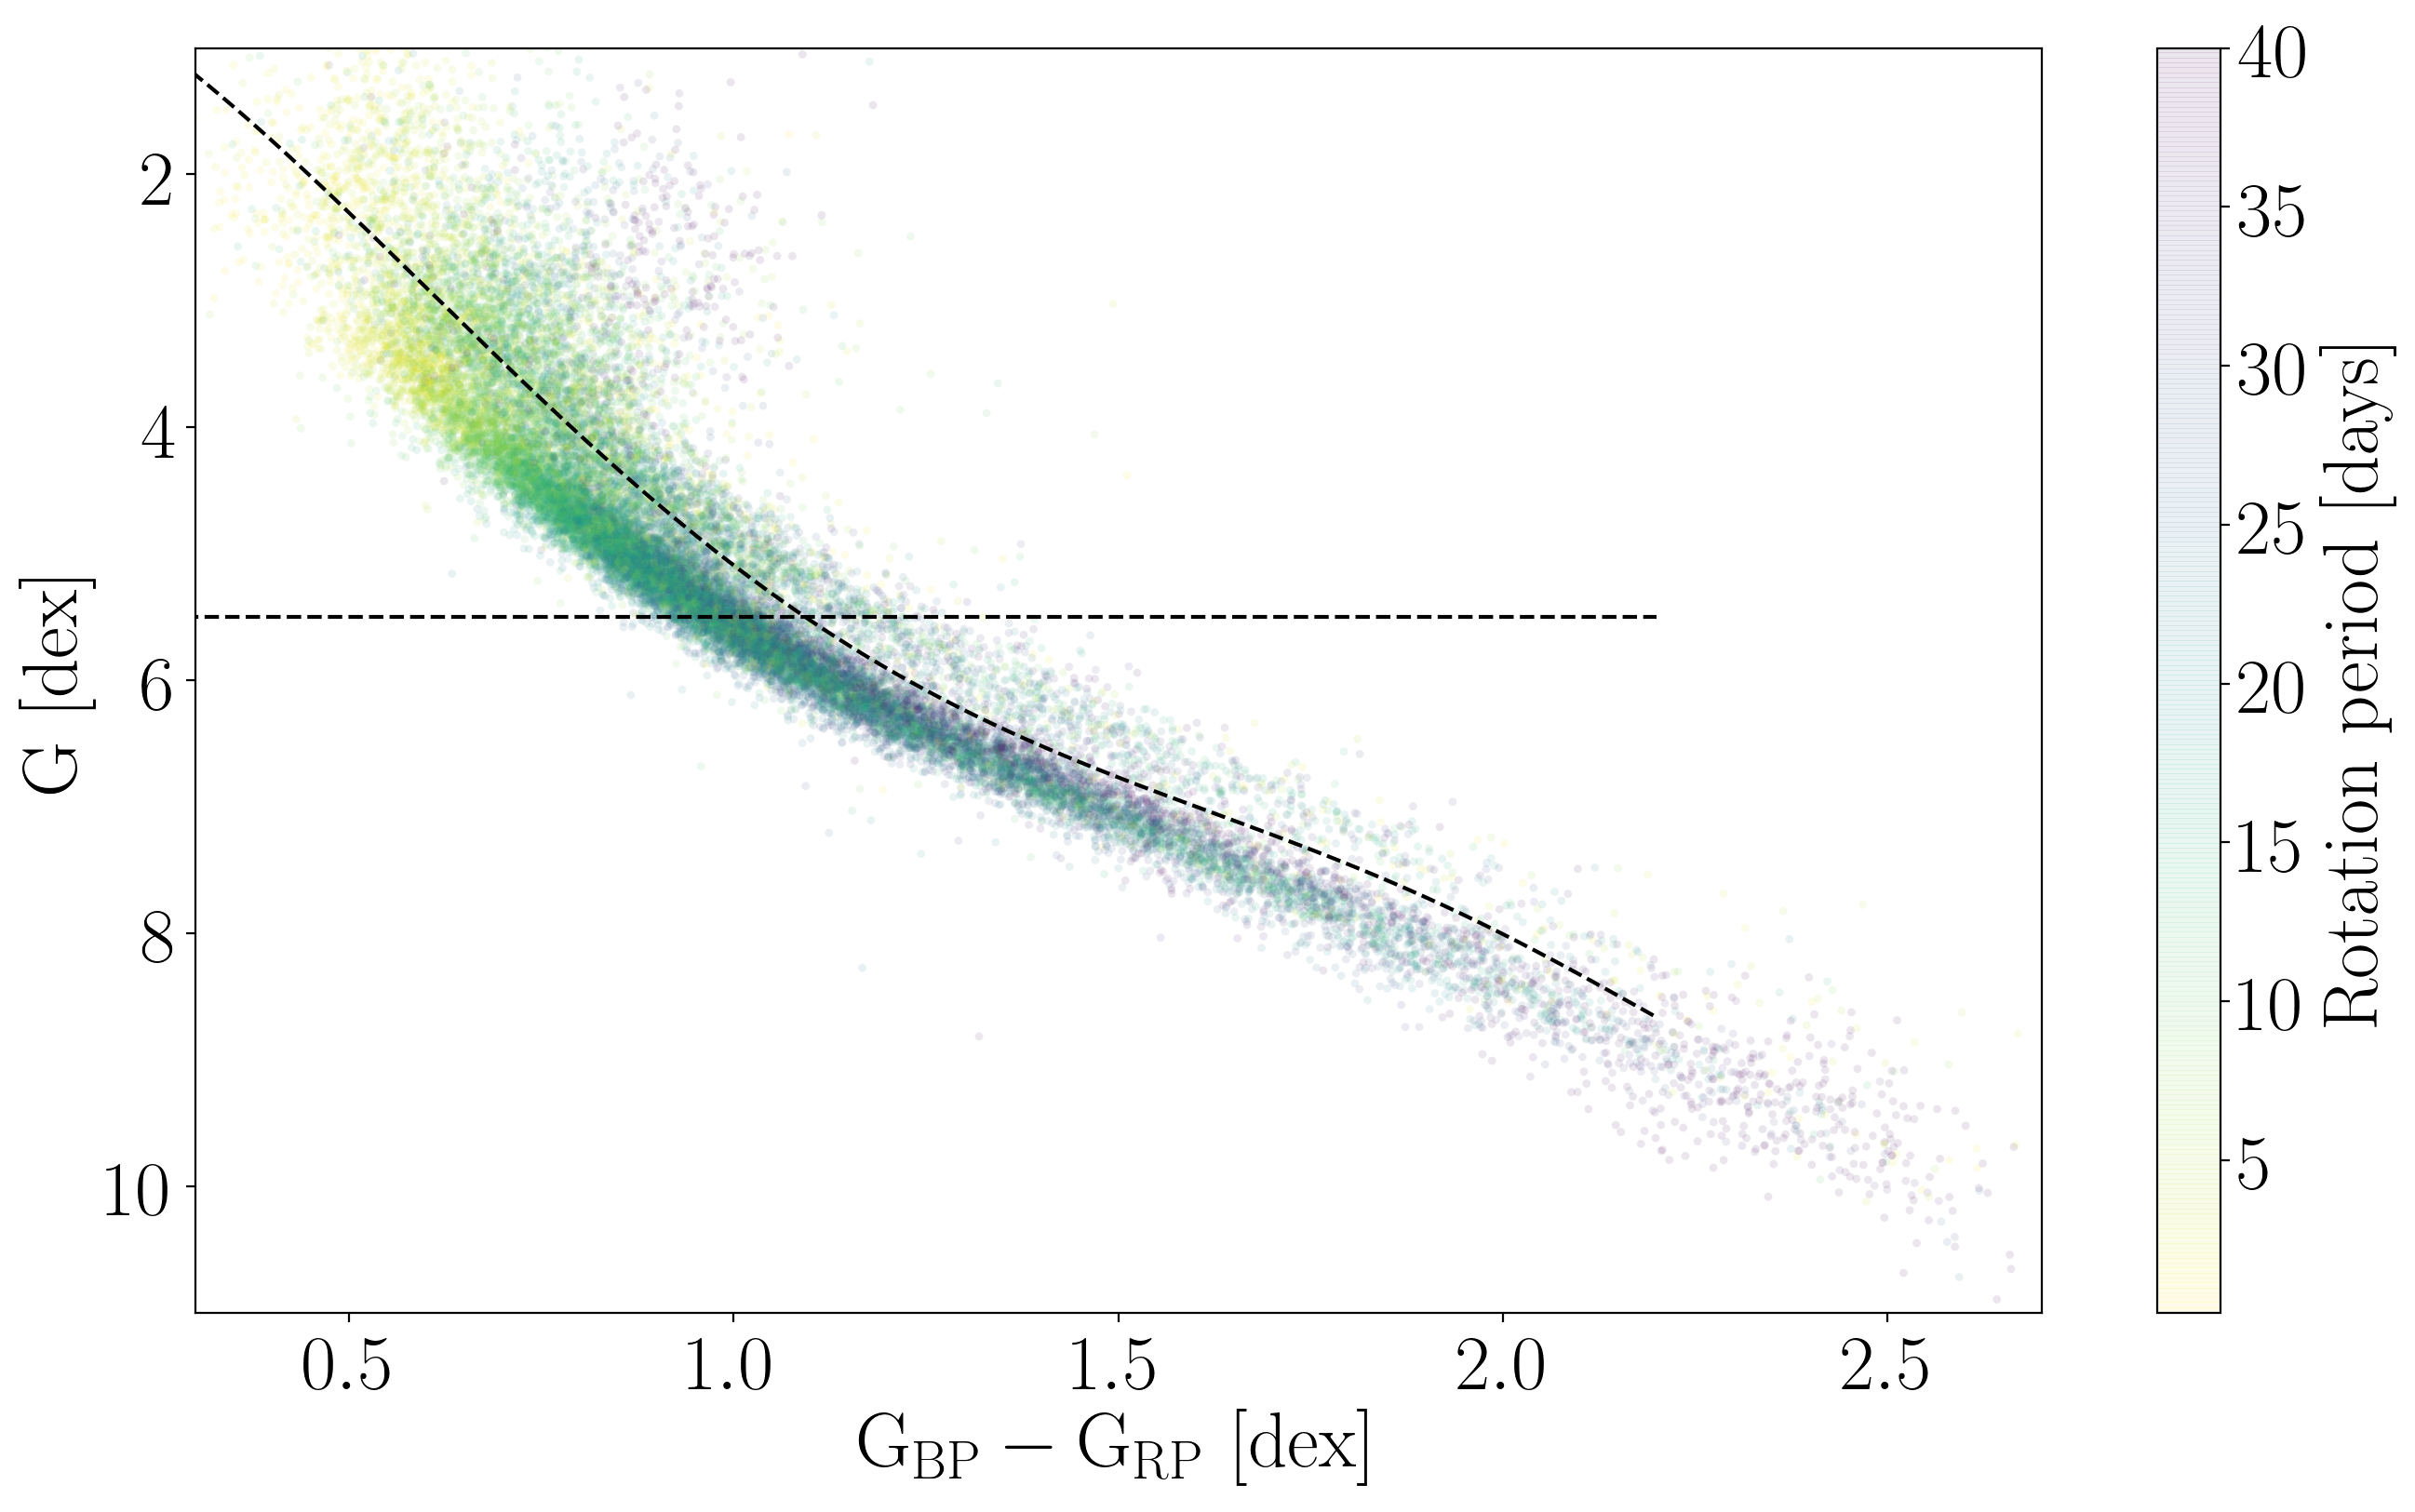

In [19]:
print(np.shape(gaia_mc))

plt.figure(figsize=(16, 9), dpi=200)
# plt.scatter(gaia_mc.phot_bp_mean_mag - gaia_mc.phot_rp_mean_mag, gaia_mc.abs_G,
plt.scatter(gaia_mc.bp_dered - gaia_mc.rp_dered, gaia_mc.abs_G,
            c=gaia_mc.Prot, s=10, alpha=.1, cmap="viridis_r", vmax=40, rasterized=True,
            edgecolor="none")
plt.xlabel("$\mathrm{G_{BP}-G_{RP}~[dex]}$")
plt.ylabel("$\mathrm{G~[dex]}$")
plt.colorbar(label="$\mathrm{Rotation~period~[days]}$")
plt.ylim(11, 1)
plt.xlim(.3, 2.7);

x = gaia_mc.bp_dered - gaia_mc.rp_dered
y = gaia_mc.abs_G

AT = np.vstack((x**6, x**5, x**4, x**3, x**2, x, np.ones_like(x)))
ATA = np.dot(AT, AT.T)
w = np.linalg.solve(ATA, np.dot(AT, y))

minb, maxb, extra = 0, 2.2, .22
xs = np.linspace(minb, maxb, 1000)
plt.plot(xs, np.polyval(w, xs) - extra, "k--")
subcut = 5.5
plt.plot(xs, np.ones_like(xs)*subcut, "k--")
plt.savefig("paper/CMD_cuts.pdf")

Cut the binaries

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


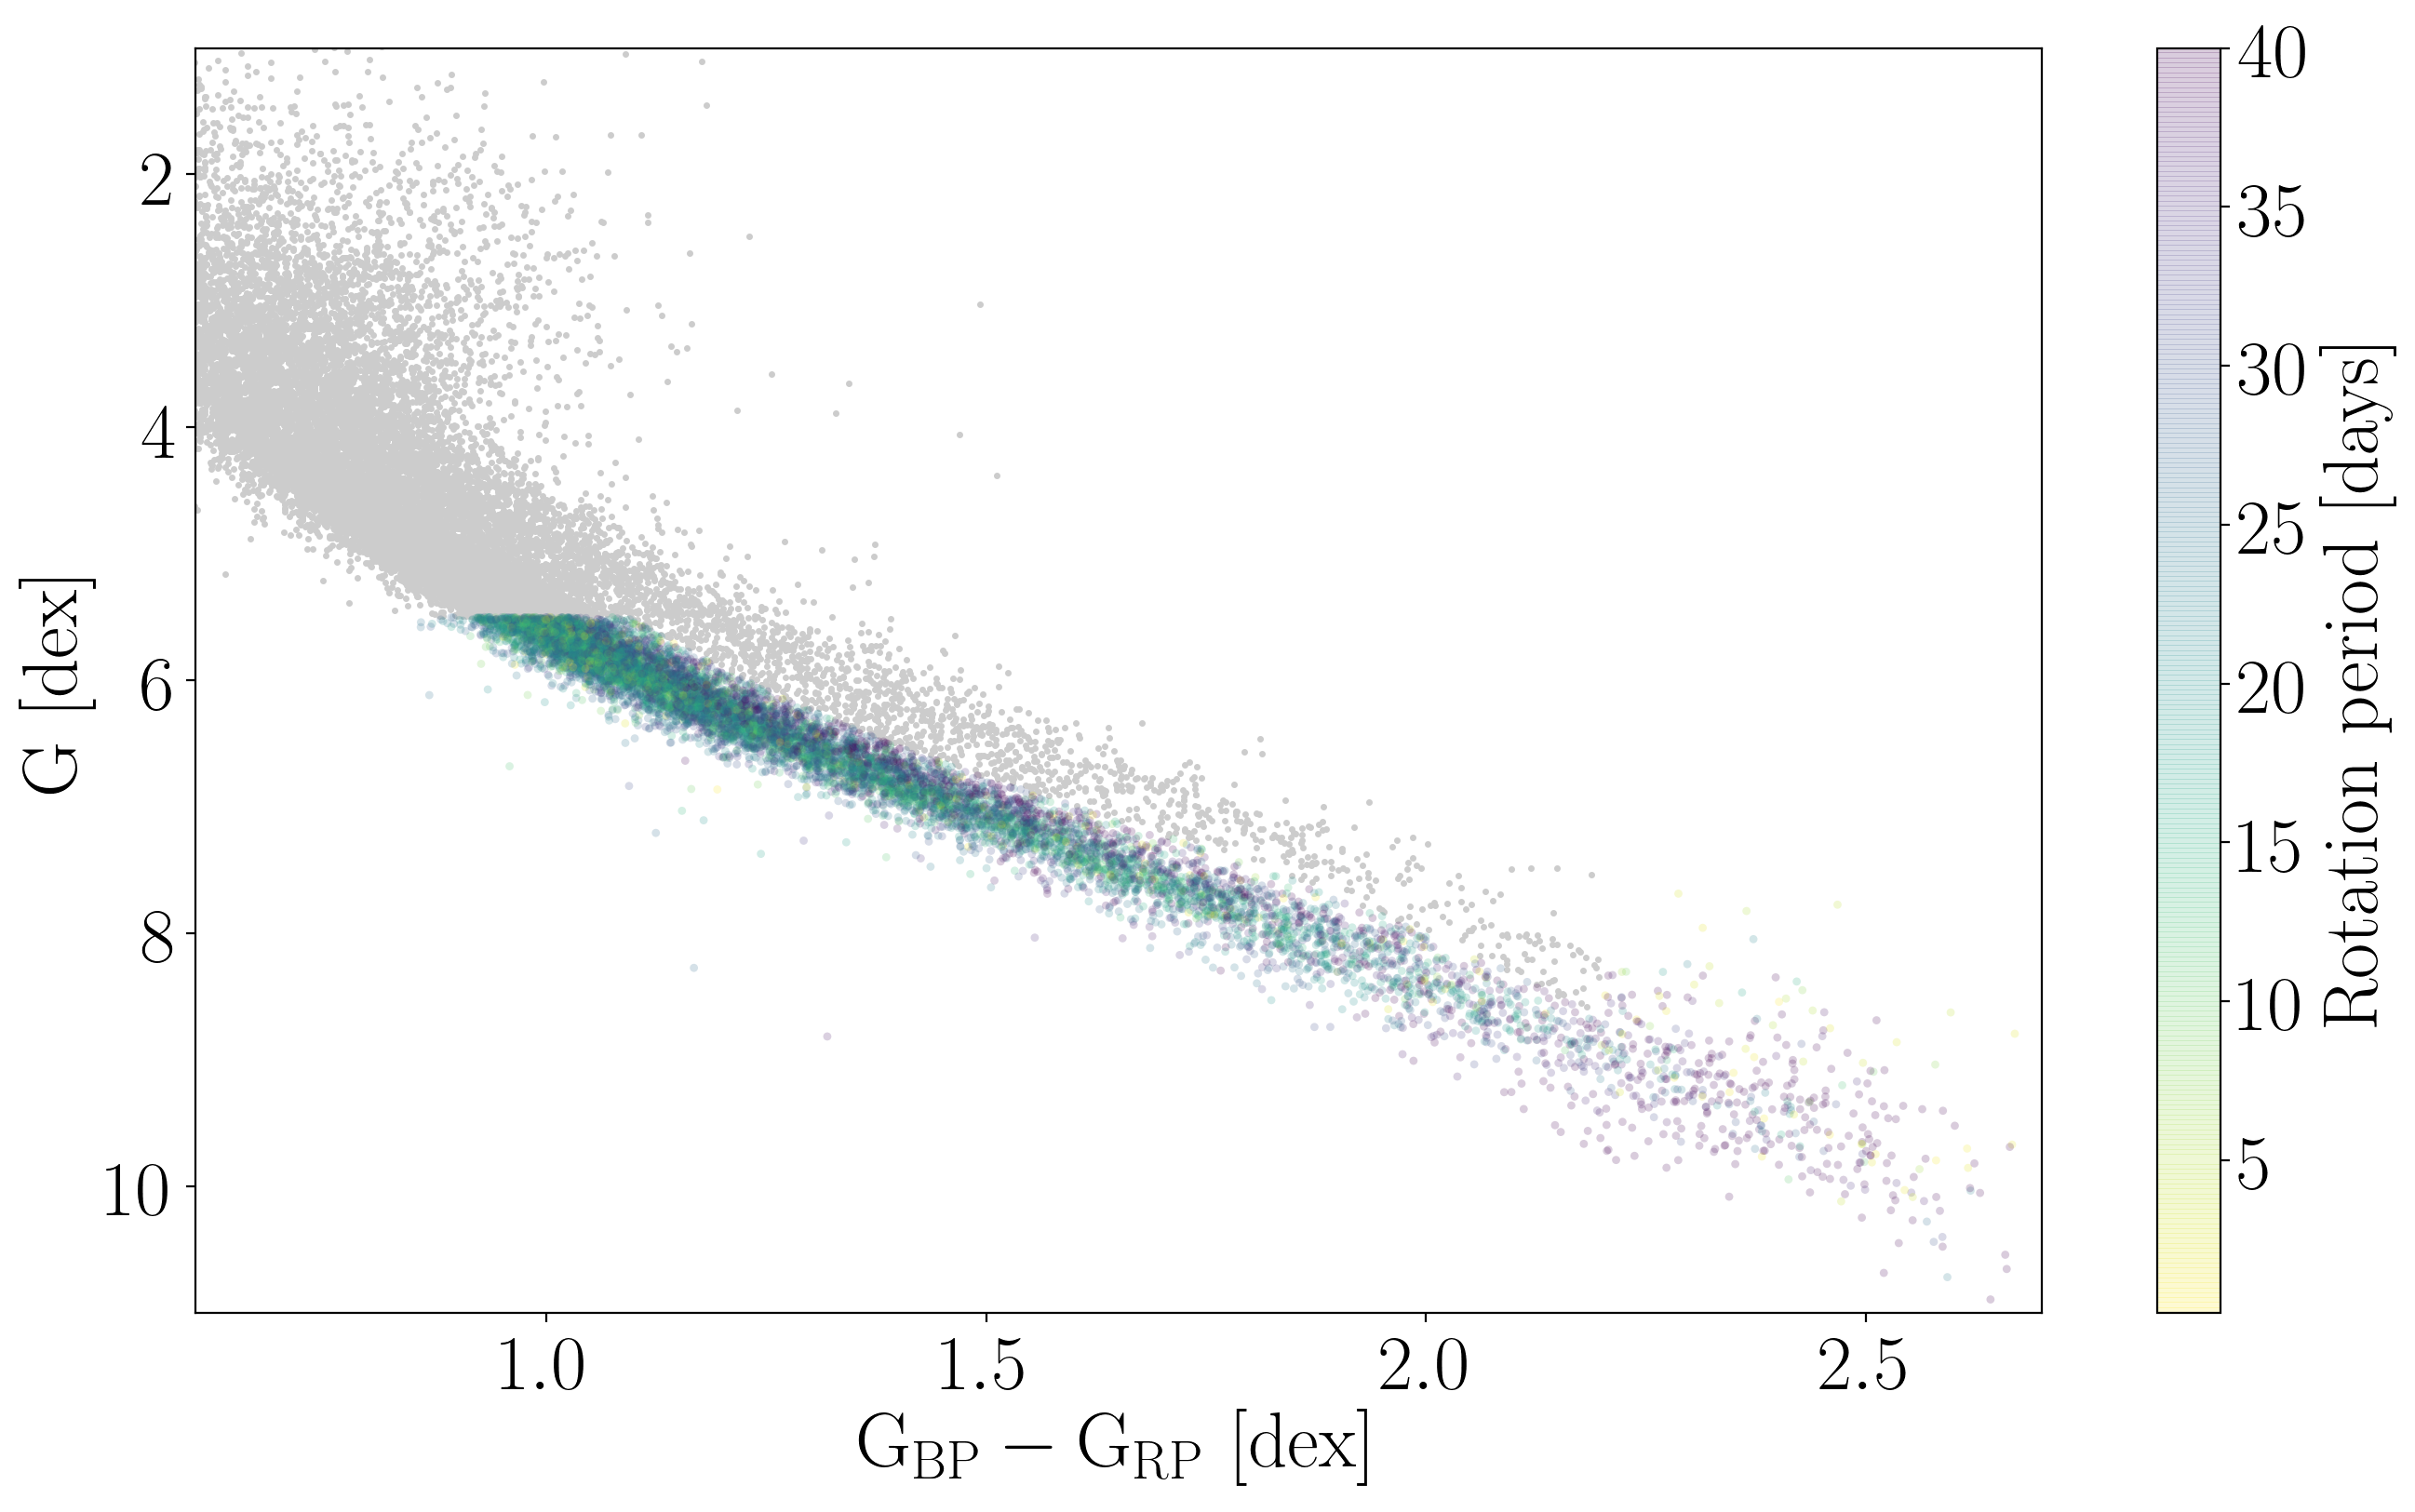

In [20]:
m = (minb < x) * (x < maxb)
m &= (y < np.polyval(w, x) - extra) + (subcut > y)

plt.figure(figsize=(16, 9), dpi=200)
plt.plot(x[m], y[m], ".", c=".8", zorder=0, ms=3)
plt.scatter(x[~m], y[~m], c=gaia_mc.Prot[~m],
            s=10, alpha=.2, cmap="viridis_r", vmax=40, zorder=1,
            edgecolor="none")
plt.xlabel("$\mathrm{G_{BP}-G_{RP}~[dex]}$")
plt.ylabel("$\mathrm{G~[dex]}$")
plt.colorbar(label="$\mathrm{Rotation~period~[days]}$")
plt.ylim(11, 1)
plt.xlim(.6, 2.7);

Flag is zero for subgiants and visual binaries, one for single stars.

In [21]:
flag = np.zeros(len(gaia_mc))
flag[~m] = np.ones(len(flag[~m])) 
gaia_mc["flag"] = flag

Calculate basic effective temperatures using Jason Curtis' relation.

In [22]:
coeffs = [8959.8112335205078, -4801.5566310882568, 1931.4756631851196,
          -2445.9980716705322, 2669.0248055458069, -1324.0671020746231,
          301.13205924630165, -25.923997443169355]
teffs = np.polyval(coeffs[::-1], gaia_mc.bp_dered - gaia_mc.rp_dered)

(3000, 7000)

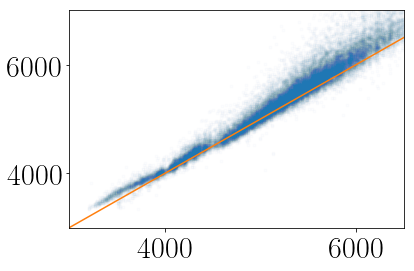

In [23]:
plt.plot(gaia_mc.Teff, teffs, ".", alpha=.01)
plt.plot(np.linspace(3000, 6500, 100), np.linspace(3000, 6500, 100))
plt.xlim(3000, 6500)
plt.ylim(3000, 7000)

In [24]:
gaia_mc["color_teffs"] = teffs

Calculate very simple gyro ages for these stars.

In [25]:
from stardate.lhf import age_model

logages = []
for i, p in enumerate(gaia_mc.Prot.values):
    logages.append(age_model(np.log10(p), gaia_mc.phot_bp_mean_mag.values[i] -
                             gaia_mc.phot_rp_mean_mag.values[i]))

gaia_mc["log_age"] = np.array(logages)
gaia_mc["age"] = (10**np.array(logages))*1e-9

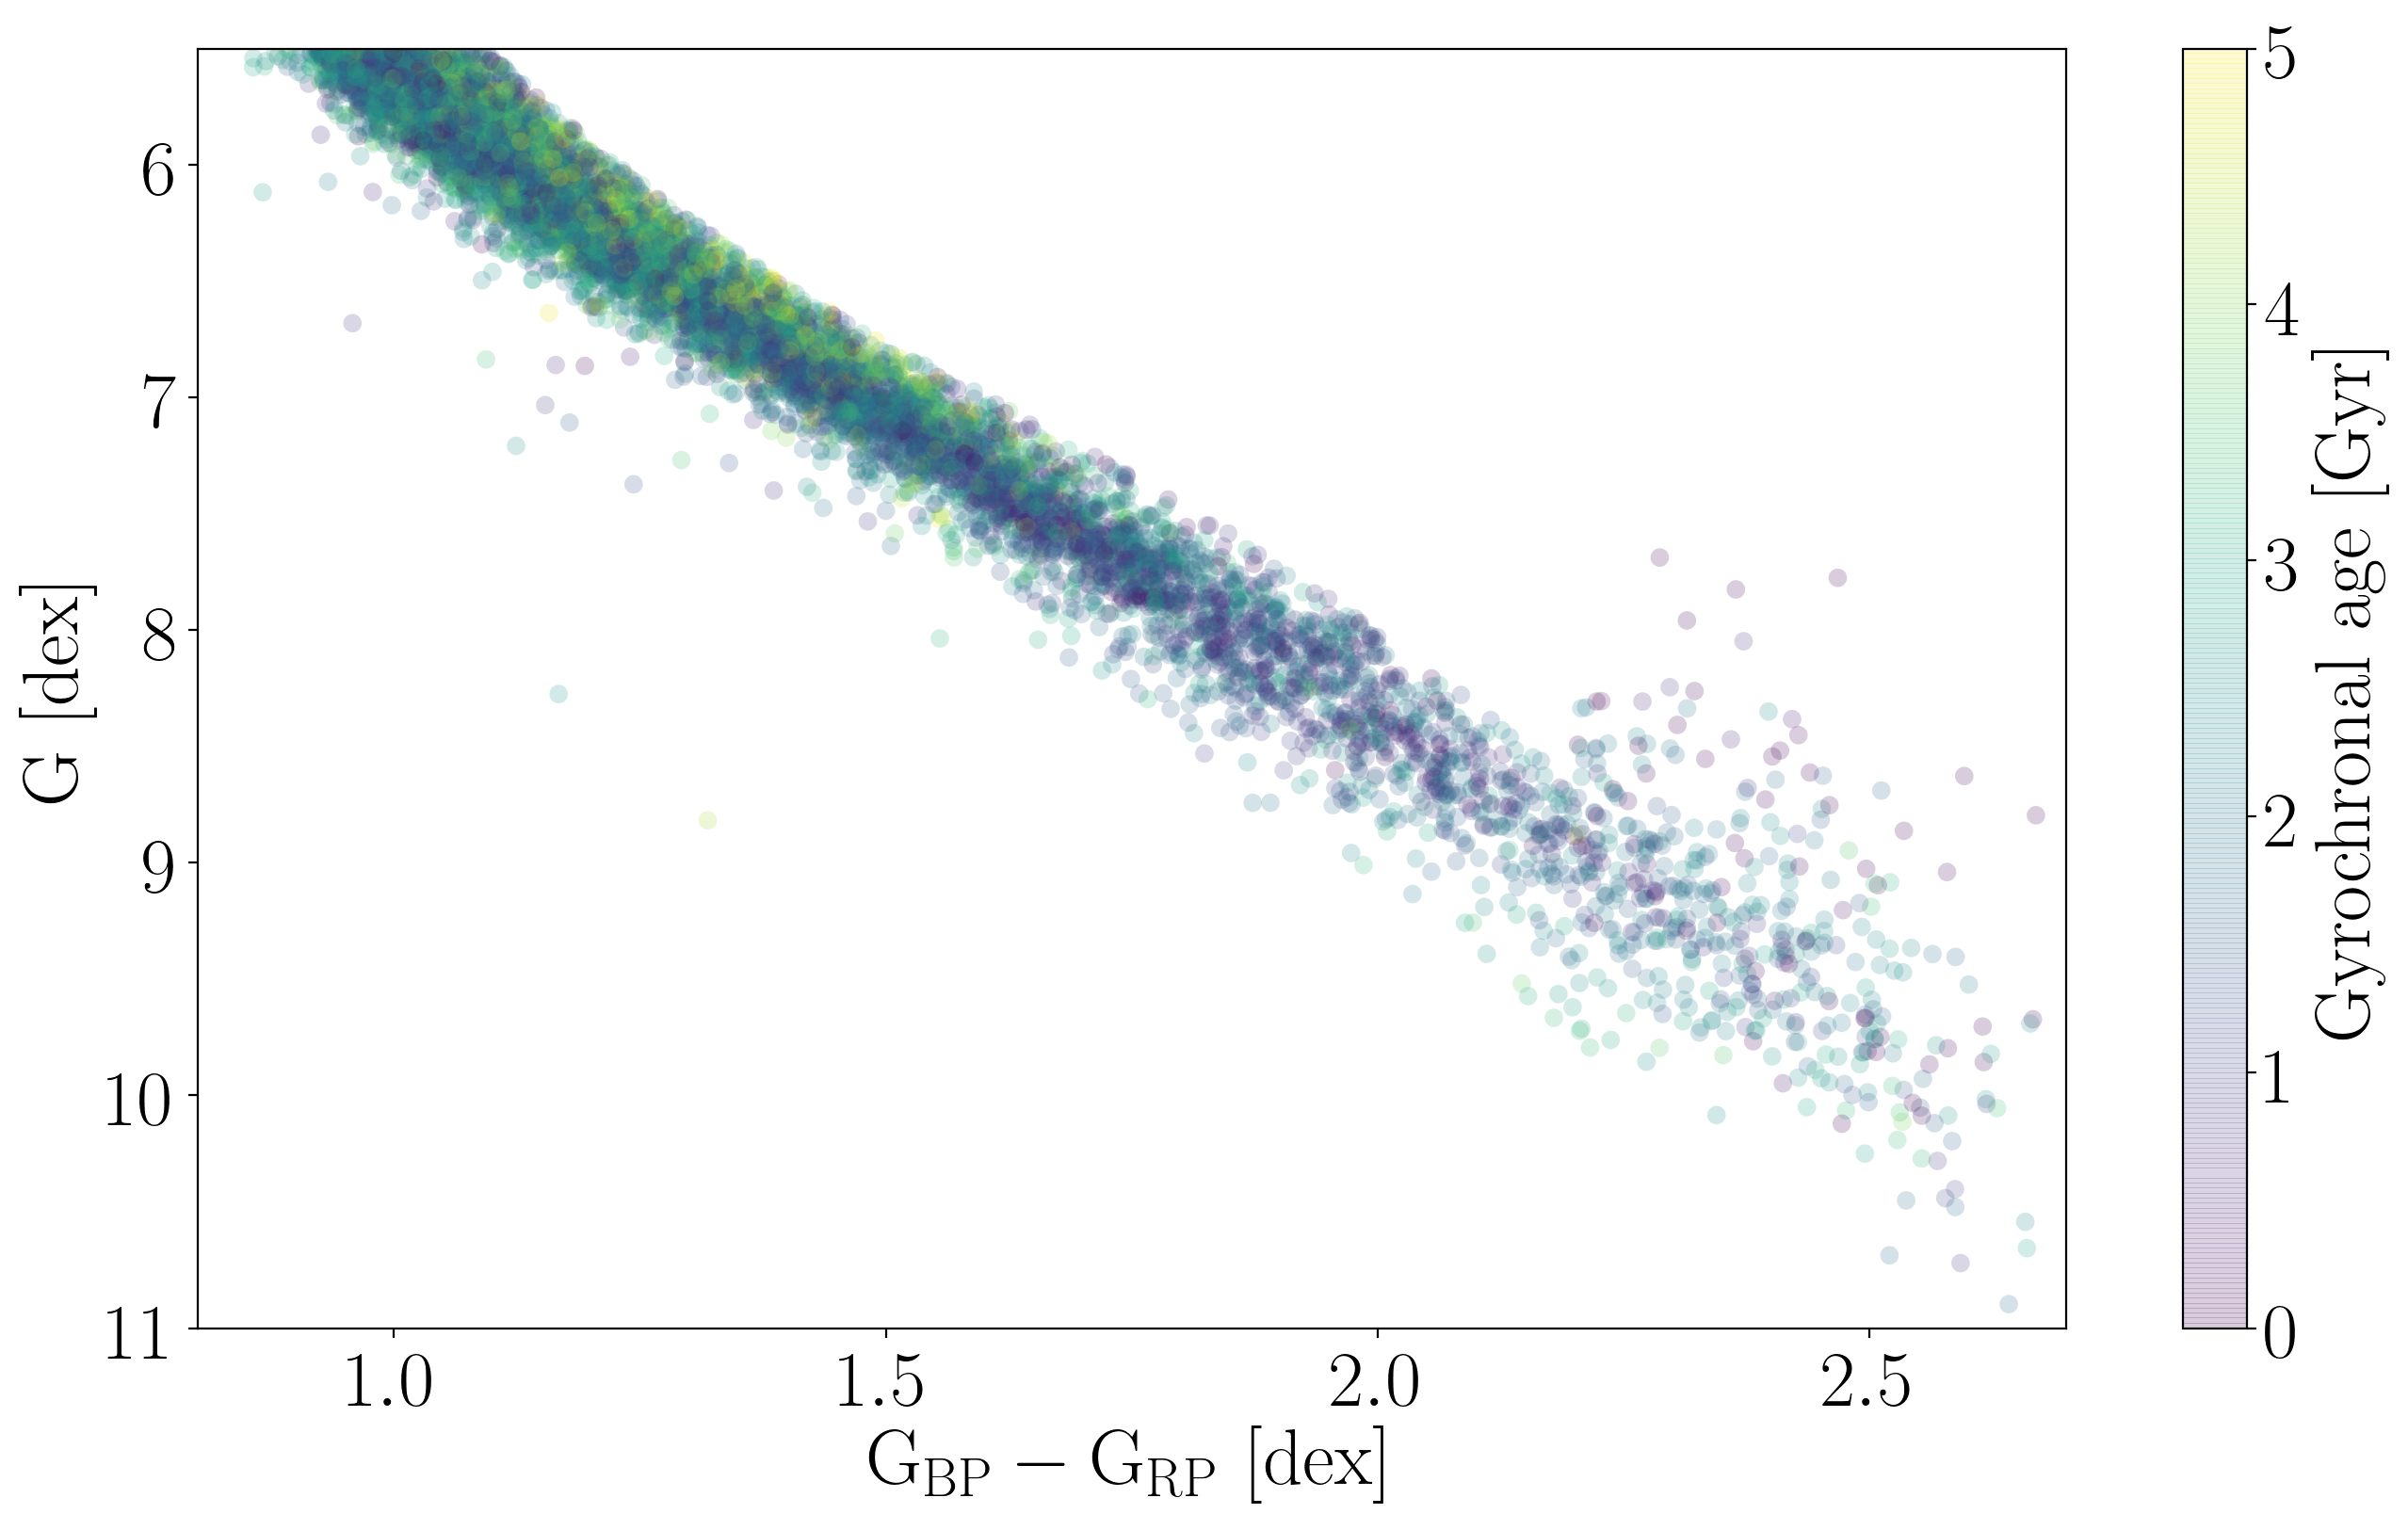

In [26]:
plt.figure(figsize=(16, 9), dpi=200)
singles = gaia_mc.flag.values == 1
plt.scatter(gaia_mc.bprp_dered.values[singles], gaia_mc.abs_G.values[singles], c=gaia_mc.age.values[singles],
            vmin=0, vmax=5, s=50, alpha=.2, cmap="viridis", rasterized=True, edgecolor="none")
plt.xlabel("$\mathrm{G_{BP}-G_{RP}~[dex]}$")
plt.ylabel("$\mathrm{G~[dex]}$")
plt.colorbar(label="$\mathrm{Gyrochronal~age~[Gyr]}$")
plt.ylim(11, 5.5)
plt.xlim(.8, 2.7);

plt.savefig("paper/age_gradient.pdf")

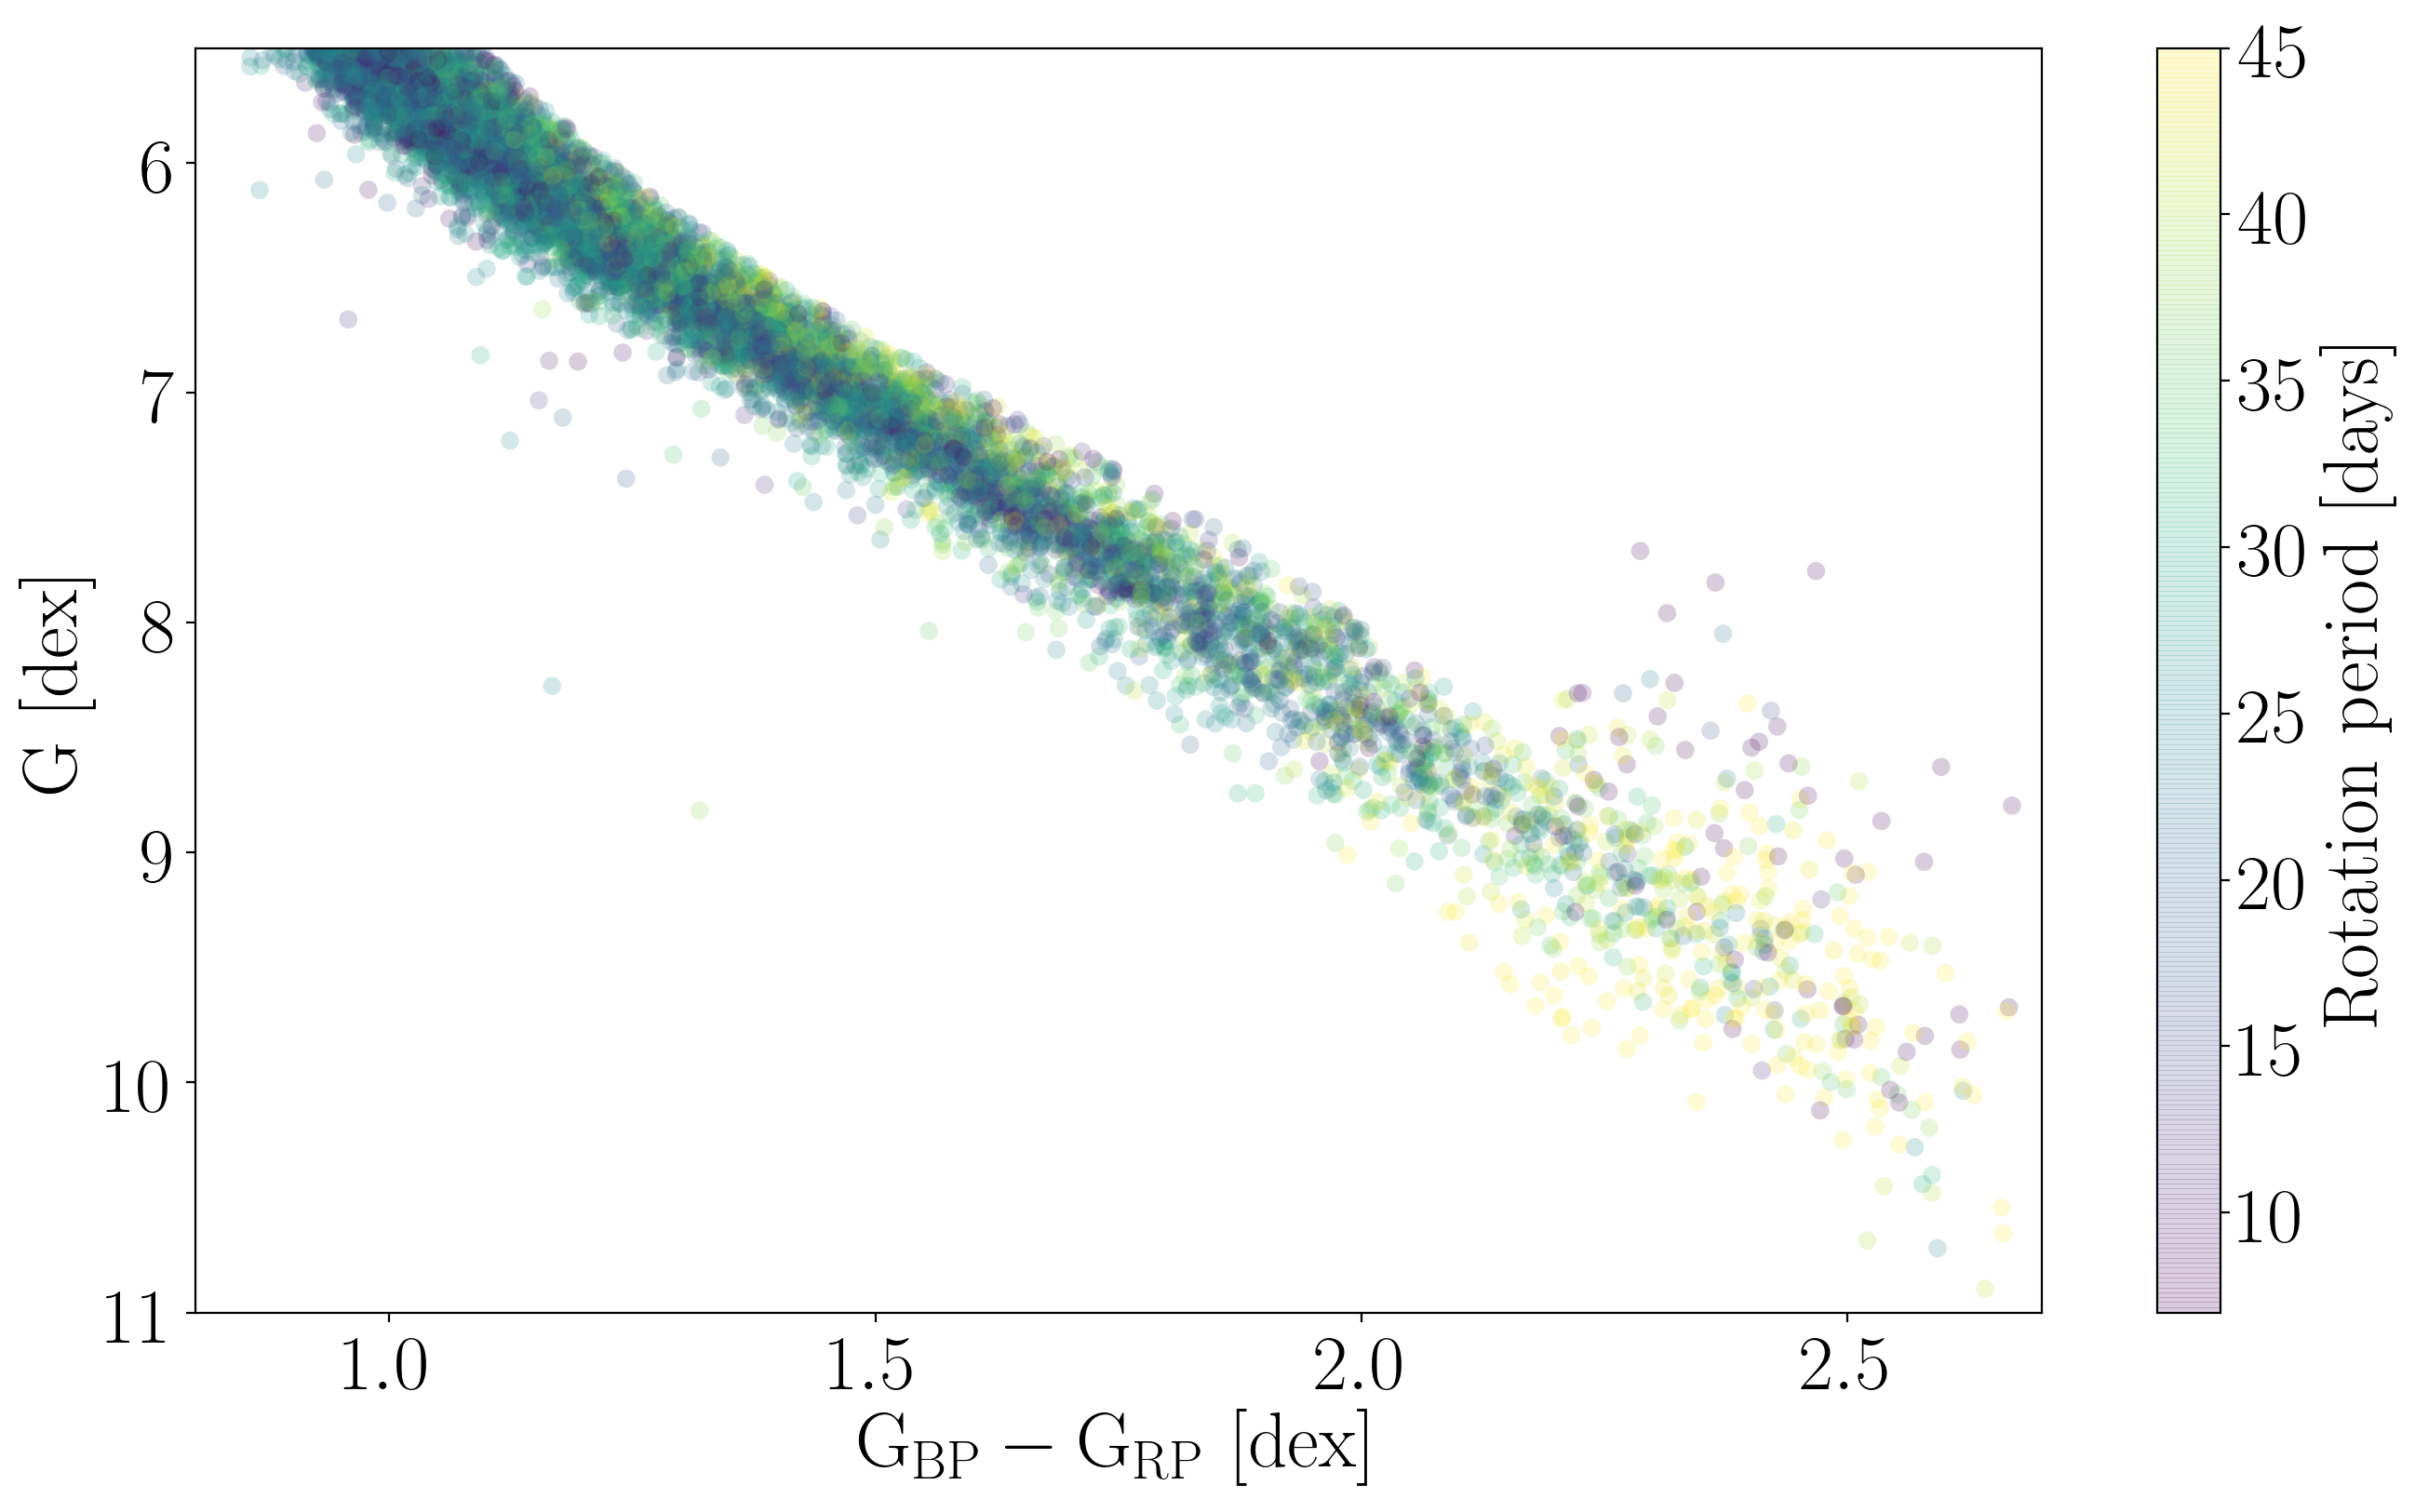

In [27]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(gaia_mc.bp_dered.values[singles] - gaia_mc.rp_dered.values[singles],
            gaia_mc.abs_G.values[singles], c=gaia_mc.Prot.values[singles], 
            vmin=7, vmax=45, s=50, alpha=.2, cmap="viridis", rasterized=True, edgecolor="none")
plt.xlabel("$\mathrm{G_{BP}-G_{RP}~[dex]}$")
plt.ylabel("$\mathrm{G~[dex]}$")
plt.colorbar(label="$\mathrm{Rotation~period~[days]}$")
plt.ylim(11, 5.5)
plt.xlim(.8, 2.7);

plt.savefig("paper/prot_gradient.pdf")

Calculate velocities.

In [28]:
from calc_velocities import calc_vb

pmb_samples, vb_samples = calc_vb(gaia_mc)
print(np.shape(pmb_samples))

(29727, 1000)


In [29]:
print(np.shape(vb_samples))
print(vb_samples[0, 0])

(29727, 1000)
-6.681655929318682


In [30]:
pmb, vb = np.median(pmb_samples, axis=1), np.median(vb_samples, axis=1)
pmb_err, vb_err = np.std(pmb_samples, axis=1), np.std(vb_samples, axis=1)
pmb_errp = np.percentile(pmb_samples, 84, axis=1) - pmb
pmb_errm = pmb - np.percentile(pmb_samples, 16, axis=1)
vb_errp = np.percentile(vb_samples, 84, axis=1) - vb
vb_errm = vb - np.percentile(vb_samples, 16, axis=1)

In [31]:
gaia_mc["vb"] = vb
gaia_mc["vb_err"] = vb_err

[ 9.79453164  9.73817415  9.72345362 ... 12.61272537 12.80761914
 13.57254096]
median =  12.271149986688771
range =  5.535925912550514 21.443722429525845
(29727,)


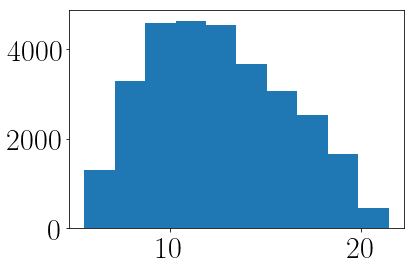

In [181]:
import astropy.units as u
from astropy.coordinates import ICRS
from astropy.coordinates import Galactic

icrs = ICRS(ra=gaia_mc.ra.values*u.degree,
            dec=gaia_mc.dec.values*u.degree)
lb = icrs.transform_to(Galactic)
# b = lb.b*u.degree
print(lb.b.value)
plt.hist(b.value);
print("median = ", np.median(b.value))
print("range = ", min(b.value), max(b.value))

from astropy.table import Table
from pyia import GaiaData
import astropy.coordinates as coord

def calc_vz(pandas_df, nsamples=1000):
    """
    Calculate W samples from a pandas DataFrame.

    Args:
        df (DataFrame): pandas dataframe containing Gaia columns

    Returns:
        W (array): samples of W velocity.
            Shape = nstars x nsamples

    """

    df = Table.from_pandas(pandas_df)
    g = GaiaData(df)
    g_samples = g.get_error_samples(size=nsamples,
                                    rnd=np.random.RandomState(seed=42))
    c_samples = g_samples.get_skycoord()
    vels = c_samples.transform_to(coord.Galactocentric)
    W = vels.v_z.value
    return np.mean(W, axis=1), np.std(W, axis=1)

mrv = gaia_mc.radial_velocity.values != 0.00
# df_rv = gaia_mc.iloc[mrv]
vz, vz_err = calc_vz(gaia_mc)
print(np.shape(vz))
vz[~mrv] = np.ones(len(vz[~mrv]))*np.nan
vz_err[~mrv] = np.ones(len(vz_err[~mrv]))*np.nan

# i = 0
# icrs = ICRS(ra=gaia_mc.ra.values*u.degree,
#             dec=gaia_mc.dec.values*u.degree,
#             distance=1./(gaia_mc.parallax.values*1e-3)*u.pc,
#             pm_ra_cosdec=gaia_mc.pmra.values*u.mas/u.yr,
#             pm_dec=gaia_mc.pmdec.values*u.mas/u.yr)
# vels = icrs.transform_to(Galactic)
# print(vels)
# # vels.pm_b
# # pm_b = np.array(vels.pm_b.value)
# # gaia_mc_cool["pm_b"] = pm_b

[2.81137782 0.87275315]


Text(0.5, 0, '$\\mathrm{v_b}$')

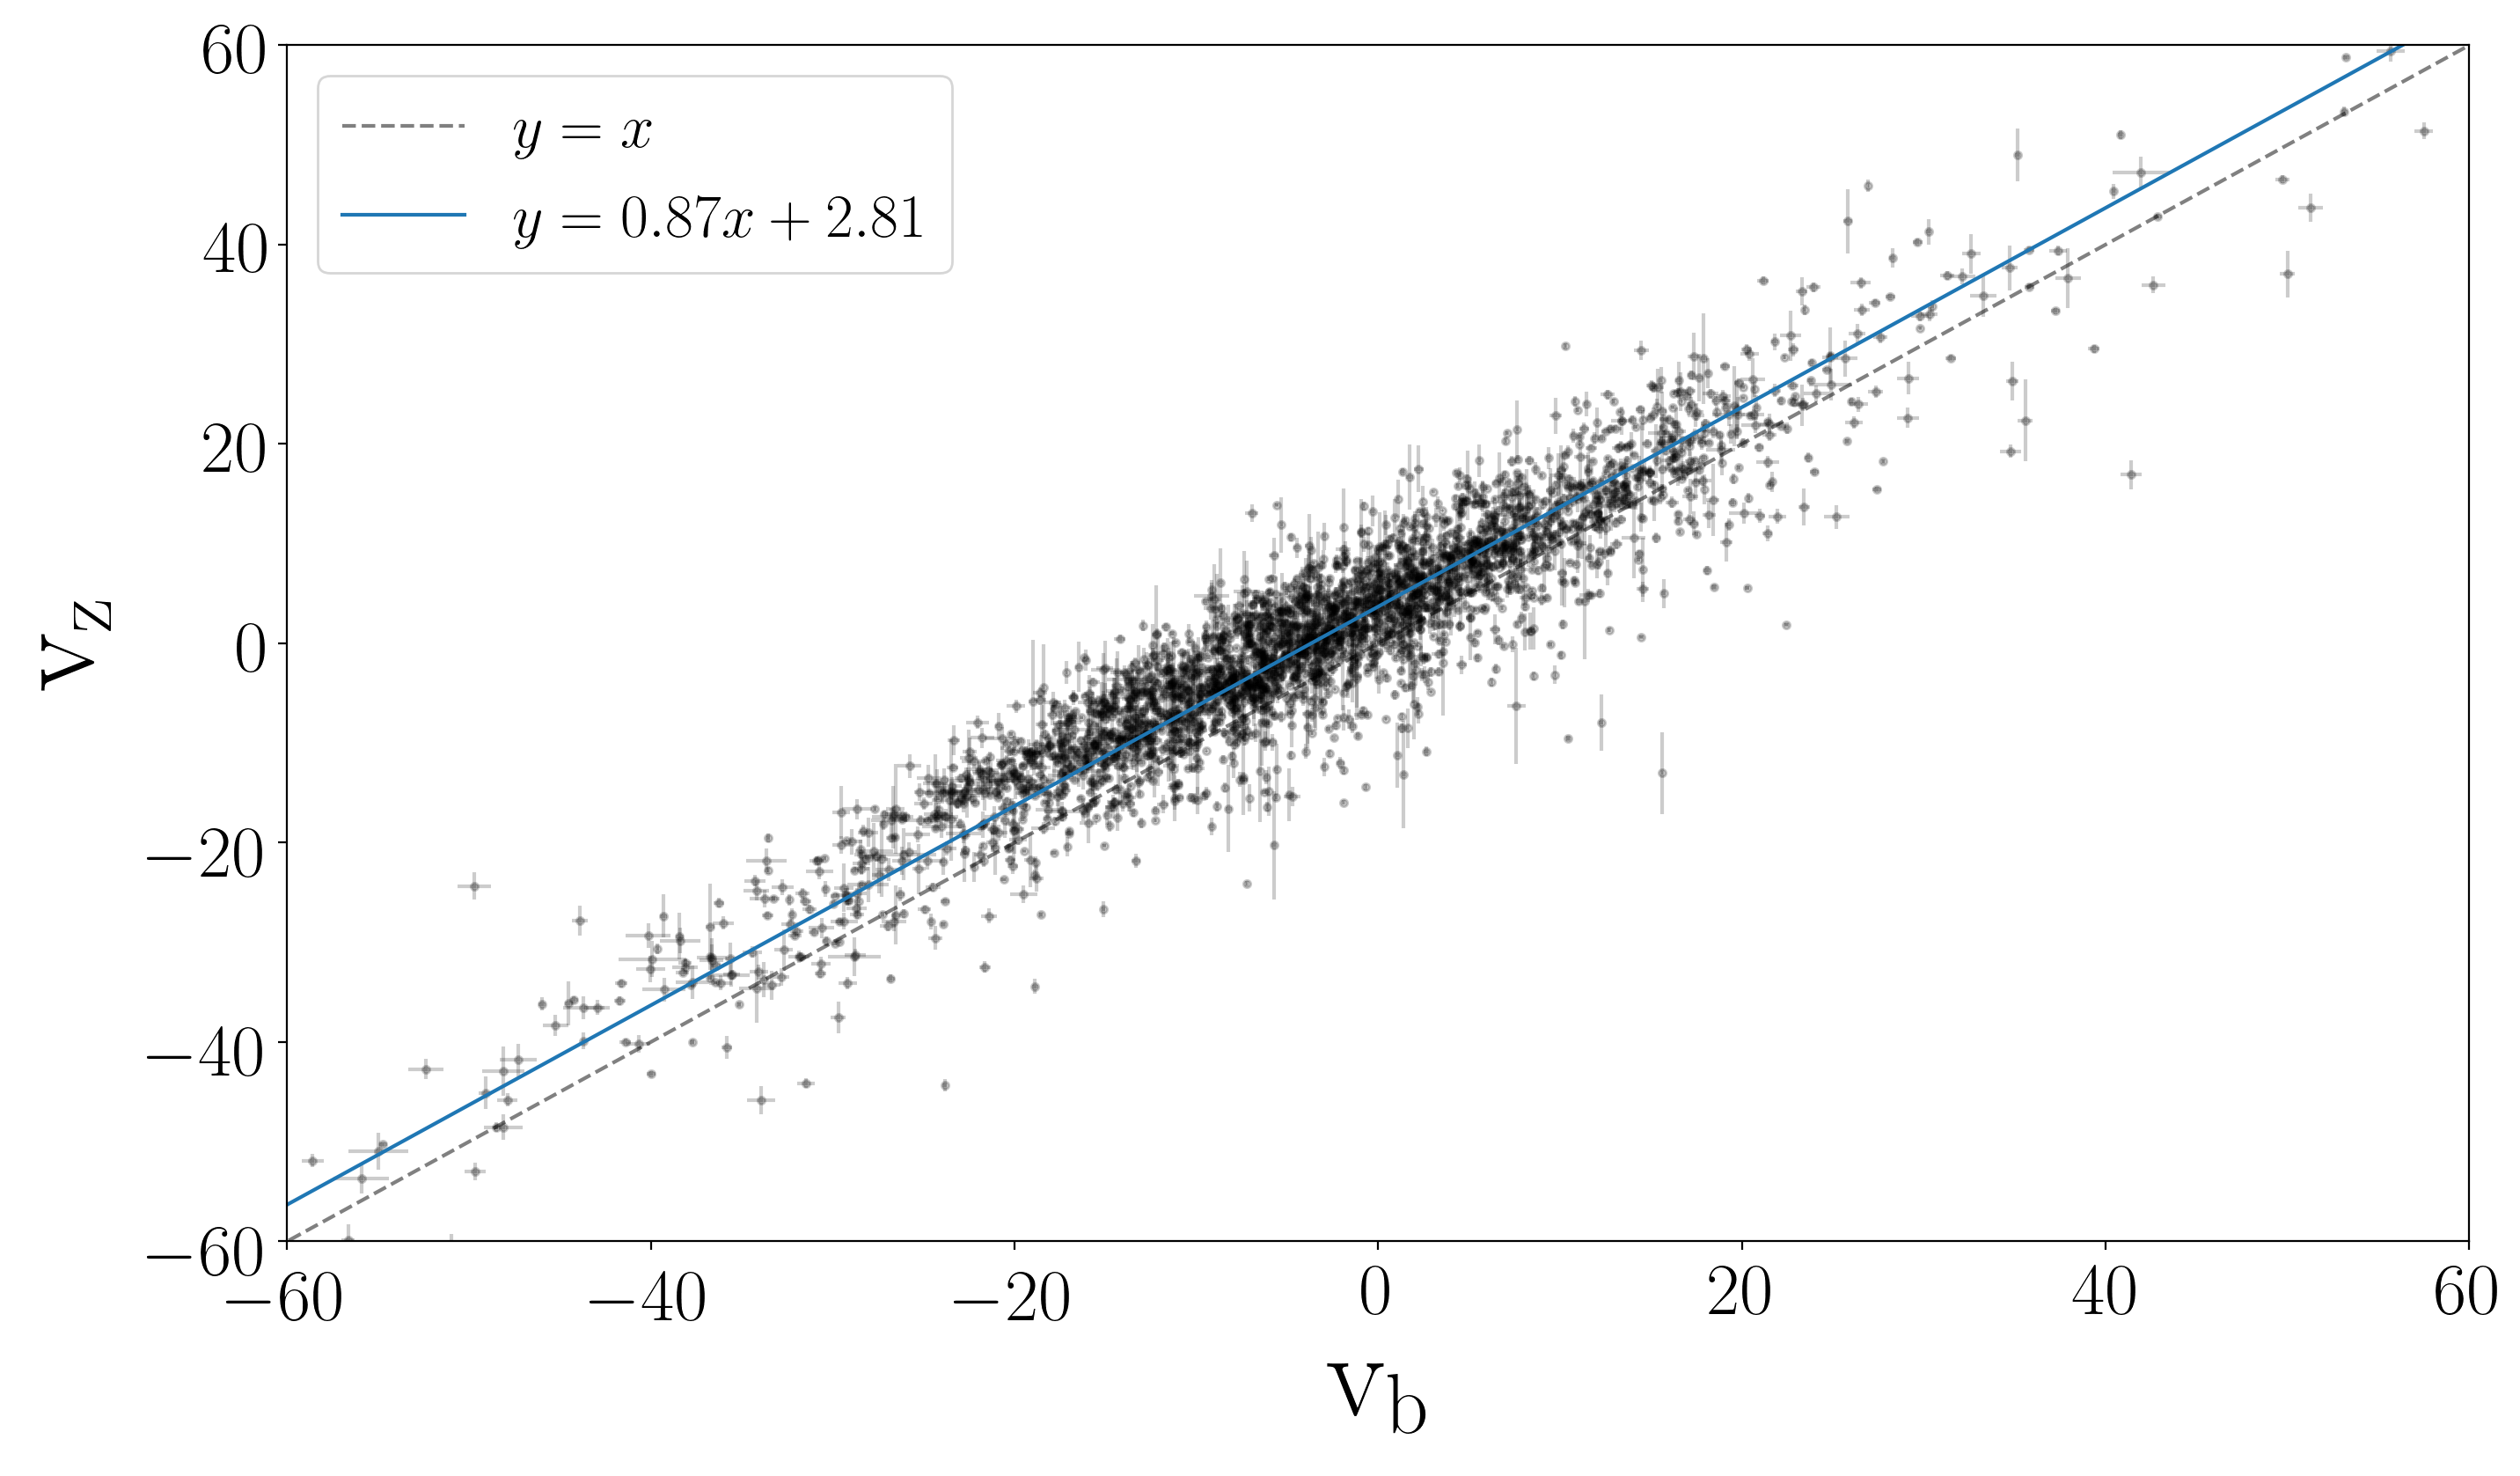

In [171]:
plt.rcParams.update({"axes.labelsize": 50, "legend.fontsize": 25})
plt.figure(figsize=(16, 9), dpi=200)

gaia_mc["vz"] = vz
gaia_mc["vz_err"] = vz_err
m = np.isfinite(gaia_mc.vz.values)

# Fit a line.
AT = np.vstack((np.ones(len(gaia_mc.vb[m])), gaia_mc.vb[m]))
C = np.eye(len(gaia_mc.vb[m]))*gaia_mc.vz_err.values[m]**2
CA = np.dot(C, AT.T)
ATCA = np.dot(AT, CA)
Cy = np.dot(C, gaia_mc.vz[m])
ATCy = np.dot(AT, Cy)
pars = np.linalg.solve(ATCA, ATCy)
print(pars)

plt.errorbar(gaia_mc.vb[m], gaia_mc.vz[m], yerr=gaia_mc.vz_err[m], xerr=gaia_mc.vb_err[m],
             fmt="k.", alpha=.2, zorder=1, label=None)
# plt.scatter(gaia_mc.vb, gaia_mc.vz, c=gaia_mc.color_teffs, zorder=3, alpha=.3, edgecolor="none")
# plt.colorbar()
xs = np.linspace(min(gaia_mc.vb[m]), 100, 100)
plt.plot(xs, xs, ls="--", color=".5", zorder=0, label="$y = x$")
plt.plot(xs, pars[0] + pars[1] + xs, zorder=2, label="$y={0:.2f}x + {1:.2f}$".format(pars[1], pars[0]))

plt.legend()
plt.xlim(-60, 60)
plt.ylim(-60, 60)
plt.ylabel("$\mathrm{v_z}$")
plt.xlabel("$\mathrm{v_b}$")

In [172]:
# nsamples = 10000

# sig_vz_samples = np.random.randn(len(df_rv.vz), nsamples)*df_rv.vz_err[:, np.newaxis] + df_rv.vz[:, np.newaxis]
# sig_vb_samples = np.random.randn(len(df_rv.vb), nsamples)*df_rv.vb_err[:, np.newaxis] + df_rv.vb[:, np.newaxis]

# stdev_sig_vz = np.std(sig_vz_samples, axis=0)  # Calculate stdev of measurements 1000 times
# sigma_vz_err = np.std(stdev_sig_vz)  # Calculate stdev of samples
# stdev_sig_vb = np.std(sig_vb_samples, axis=0)
# sigma_vb_err = np.std(stdev_sig_vb)

# sigma_vz = np.std(df_rv.vz)
# sigma_vb = np.std(df_rv.vb)

# print("sigma_vz = {0:.2f} +/- {1:.2f}, sigma_vb = {2:.2f} +/i {3:.2f}".format(
#       sigma_vz, sigma_vz_err, sigma_vb, sigma_vb_err))

In [174]:
def calc_dispersion_and_dispersion_err(v, verr, nsamples):
    """
    Calculate velocity dispersion and uncertainty on the dispersion,
    given velocities and uncertainties.
    """
    
    # Calculate velocity samples
    v_samples = np.random.randn((len(v)), nsamples)*verr[:, np.newaxis] + v[:, np.newaxis]
    
    # Calculate velocity dispersion samples
    dispersion_samples = np.std(v_samples, axis=0)
    dispersion = np.mean(dispersion_samples)
    
    # Calculate uncertainty on velocity dispersion
    dispersion_err = np.std(dispersion_samples)
    
    return dispersion, dispersion_err

dvz, dvz_err = calc_dispersion_and_dispersion_err(gaia_mc.vz[m], gaia_mc.vz_err[m], 10000)
dvb, dvb_err = calc_dispersion_and_dispersion_err(gaia_mc.vb[m], gaia_mc.vb_err[m], 10000)
print(dvz, dvz_err, dvb, dvb_err)

13.911569593180163 0.05265176710460548 14.190411119264903 0.05664677903433771


Calculate v_ra, v_dec and v_b

In [175]:
# import astropy.coordinates as coord
# import astropy.units as u
# d = coord.Distance(parallax=df.parallax.values * u.mas)
# vra = (df.pmra.values*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
# vdec = (df.pmdec.values*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())

# c = coord.SkyCoord(ra=df.ra.values*u.deg, dec=df.dec.values*u.deg, distance=d, 
#                    pm_ra_cosdec=df.pmra.values*u.mas/u.yr,
#                    pm_dec=df.pmdec.values*u.mas/u.yr)
# gal = c.galactic
# v_b = (gal.pm_b * gal.distance).to(u.km/u.s, u.dimensionless_angles())

# df["v_b"] = v_b.value
# df["v_ra"] = vra.value
# df["v_dec"] = vdec.value

Calculate actions for stars with RVs.

In [176]:
mrv = gaia_mc.radial_velocity.values != 0.00
print(len(gaia_mc.radial_velocity[mrv]), "stars in McQuillan with Gaia RVs")

3159 stars in McQuillan with Gaia RVs


In [177]:
import actions as ac
from tqdm import trange

jz = np.ones(len(gaia_mc.ra.values))*np.nan
for i in trange(len(gaia_mc.ra.values)):
    if gaia_mc.radial_velocity.values[i] != 0.00:
        try:
            R_kpc, phi_rad, z_kpc, vR_kms, vT_kms, vz_kms, jR, Lz, Jz = ac.action(
                gaia_mc.ra.values[i], gaia_mc.dec.values[i],
                1./gaia_mc.parallax.values[i], 
                gaia_mc.pmra.values[i], gaia_mc.pmdec.values[i],
                gaia_mc.radial_velocity.values[i])
            jz[i] = Jz
        except:
            UnboundError

gaia_mc["jz"] = jz

100%|██████████| 29727/29727 [02:37<00:00, 188.36it/s]


Still to do: calculate action uncertainties, e.g.:

In [36]:
# def action_with_err(ra_dec, dec_deg, parallax_mas, pmra_masyr, pmdec_masyr, rv_kms, rv_err, cov):
#     """
#     Calculate actions with uncertainties, given a covariance matrix.
    
#     Args:
#         ra_deg
#         dec_deg
#         parallax_mas
#         pmra_masyr
#         pmdec_masyr
#         rv_kms
#         rv_err
#         cov
        
#     cov = [[ra_err**2        ra_dec_corr       ra_parallax_corr    ra_pmra_corr       ra_pmdec_corr]
#            [ra_dec_corr      dec_err**2        dec_parallax_corr   dec_pmra_corr      dec_pmdec_corr]
#            [ra_parallax_corr dec_parallax_corr parallax_err**2     parallax_pmra_corr parallax_pmdec_corr]
#            [ra_pmra_corr     dec_pmra_corr     parallax_pmra_corr  pmra_err**2        pmra_pmdec_corr]
#            [ra_pmdec_corr    dec_pmdec_corr    parallax_pmdec_corr pmra_pmdec_corr    pmdec_err**2]]
#     """

Save Gaia-Mcquillan crossmatch with velocities to csv.

In [178]:
gaia_mc.to_csv("gaia_mc.csv")

In [ ]:
import read_mist_models
iso = read_mist_models.ISO(
    "/Users/rangus/projects/astro-viz/data/MIST_v1.2_vvcrit0.0_UBVRIplus/" \
    "MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_UBVRIplus.iso")

from tqdm import tqdm
tmin, tmax = 4000, 6200
Lmin, Lmax = -1.2, .5

def get_properties(iso, tmin, tmax, Lmin, Lmax):
    teffs, Ls, ages, G, bp, rp = [[] for i in range(6)]
    for i, a in enumerate(tqdm(np.log10(np.linspace(1, 14, 4)*1e9))):
    
        age_ind = iso.age_index(a) #returns the index for the desired age
        logTeff = iso.isos[age_ind]['log_Teff']
        logL = iso.isos[age_ind]['log_L']
        age = (10**iso.isos[age_ind]["log10_isochrone_age_yr"])*1e-9
        g = iso.isos[age_ind]["Gaia_G_DR2Rev"]
        _rp = iso.isos[age_ind]["Gaia_RP_DR2Rev"]
        _bp = iso.isos[age_ind]["Gaia_BP_DR2Rev"]
    
        teff = 10**logTeff
        m = (teff < tmax) * (tmin < teff)
        m &= (logL < Lmax) * (Lmin < logL)

        Ls.append(logL[m])
        teffs.append(teff[m])
        ages.append(age[m])
        G.append(g[m])
        rp.append(_rp[m])
        bp.append(_bp[m])
    
    return teffs, Ls, ages, G, bp, rp

teffs, Ls, ages, G, bp, rp = get_properties(iso, tmin, tmax, Lmin, Lmax)

plt.figure(figsize=(16, 9))
colors = ["k", "C0", "C1", "C2"]
for i in range(len(G)):
    plt.plot(bp[i]-rp[i], G[i], color=colors[i], ls="-",
             label="${0:.1f}~Gyr$".format(ages[i][0]), zorder=0)
    print(ages[i][0])
    
plt.legend()
plt.ylabel('$G$')
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylim(8, 3)
plt.xlim(.6, 1.7)

If you want to make this smaller, the Gaia columns to keep are:

In [ ]:
mini_gaia = pd.DataFrame(dict({"source_id": gaia.source_id,
                               "kepid": gaia.kepid,
                               "ra": gaia.ra, "ra_error": gaia.ra_error,
                               "dec": gaia.dec, "dec_error": gaia.dec_error,
                               "parallax": gaia.parallax,
                               "parallax_error": gaia.parallax_error,
                               "pmra": gaia.pmra, "pmra_error": gaia.pmra_error,
                               "pmdec": gaia.pmdec, "pmdec_error": gaia.pmdec_error,
                               "ra_dec_corr": gaia.ra_dec_corr,
                               "ra_parallax_corr": gaia.ra_parallax_corr,
                               "ra_pmra_corr": gaia.ra_pmra_corr,
                               "ra_pmdec_corr": gaia.ra_pmdec_corr,
                               "dec_parallax_corr": gaia.dec_parallax_corr,
                               "dec_pmra_corr": gaia.dec_pmra_corr,
                               "dec_pmdec_corr": gaia.dec_pmdec_corr,
                               "parallax_pmra_corr": gaia.parallax_pmra_corr,
                               "parallax_pmdec_corr": gaia.parallax_pmdec_corr,
                               "pmra_pmdec_corr": gaia.pmra_pmdec_corr,
                               "radial_velocity": gaia.radial_velocity,
                               "radial_velocity_error": gaia.radial_velocity_error,
                               "G": gaia.phot_g_mean_mag,
                               "bp": gaia.phot_bp_mean_mag,
                               "rp": gaia.phot_rp_mean_mag,
                               "jmag": gaia.jmag,
                               "hmag": gaia.hmag,
                               "kmag": gaia.kmag
                              }))

Let's try running stardate on one of these stars.

In [34]:
import stardate as sd

Only use metallicities if they're spectroscopic.

In [35]:
i = 0
if df["n_[Fe/H]i"].values[i] == "SPE":
    iso_params = {"g": (df.g_final.values[i], df.g_final_err.values[i]),
                  "r": (df.r_final.values[i], df.r_final_err.values[i]),
                  "J": (df.Jmag.values[i], df.e_Jmag.values[i]),
                  "H": (df.Hmag.values[i], df.e_Hmag.values[i]),
                  "K": (df.Kmag.values[i], df.e_Kmag.values[i]),
                  "feh": (df["[Fe/H]i"].values[i], .05),
                  "parallax": (df.plx[i].values*1e3, df.plxe.values[i]*1e3)}
else:
    iso_params = {"g": (df.g_final.values[i], df.g_final_err.values[i]),
                  "r": (df.r_final.values[i], df.r_final_err.values[i]),
                  "J": (df.Jmag.values[i], df.e_Jmag.values[i]),
                  "H": (df.Hmag.values[i], df.e_Hmag.values[i]),
                  "K": (df.Kmag.values[i], df.e_Kmag.values[i]),
                  "parallax": (df.plx.values[i]*1e3, df.plxe.values[i]*1e3)}
    
print(iso_params)
print(df.Prot.values[i], df.Av.values[i], df.Av_errm.values[i])

prot, prot_err = df.Prot.values[i], df.Prot.values[i]*.05
star = sd.Star(iso_params, prot=prot, prot_err=prot_err,
               Av=df.Av.values[i], Av_err=df.Av_std.values[i],
               savedir="posteriors", filename="test")

{'g': (16.087088578099998, 0.0203150148217), 'r': (15.2187902098, 0.020088848135900002), 'J': (13.652000000000001, 0.026000000000000002), 'H': (13.099, 0.025), 'K': (13.003, 0.026000000000000002), 'parallax': (1.7670000000000001, 0.0248)}
13.765 0.23306999223679303 0.00932279805511238


In [36]:
star.fit(max_n=10000, thin_by=100)

100%|██████████| 10000/10000 [01:38<00:00, 101.14it/s]


In [37]:
from stardate import load_samples, read_samples

# Load the samples.
flatsamples, samples, prior_samples, posterior_samples = load_samples("posteriors/test.h5", burnin=50)

# Extract the median and maximum likelihood parameter estimates from the samples.
results = read_samples(flatsamples)

# Print the results as a pandas dataframe.
results

EEP_med  EEP_errm  EEP_errp   EEP_std      EEP_ml  age_med_gyr  \
0  281.692558  3.059793    3.2398  8.310309  281.140365     0.972628   

   age_errm  age_errp  age_std  age_ml_gyr  ...    distance_errm  \
0   0.08027  0.093708  0.58478    0.959946  ...         8.033859   

   distance_errp  distance_std_pc  distance_ml    Av_med  Av_errm   Av_errp  \
0       7.998642        21.331033   564.919469  0.232051  0.01011  0.010078   

     Av_std    Av_ml  index  
0  0.011117  0.23126      0  

[1 rows x 26 columns]

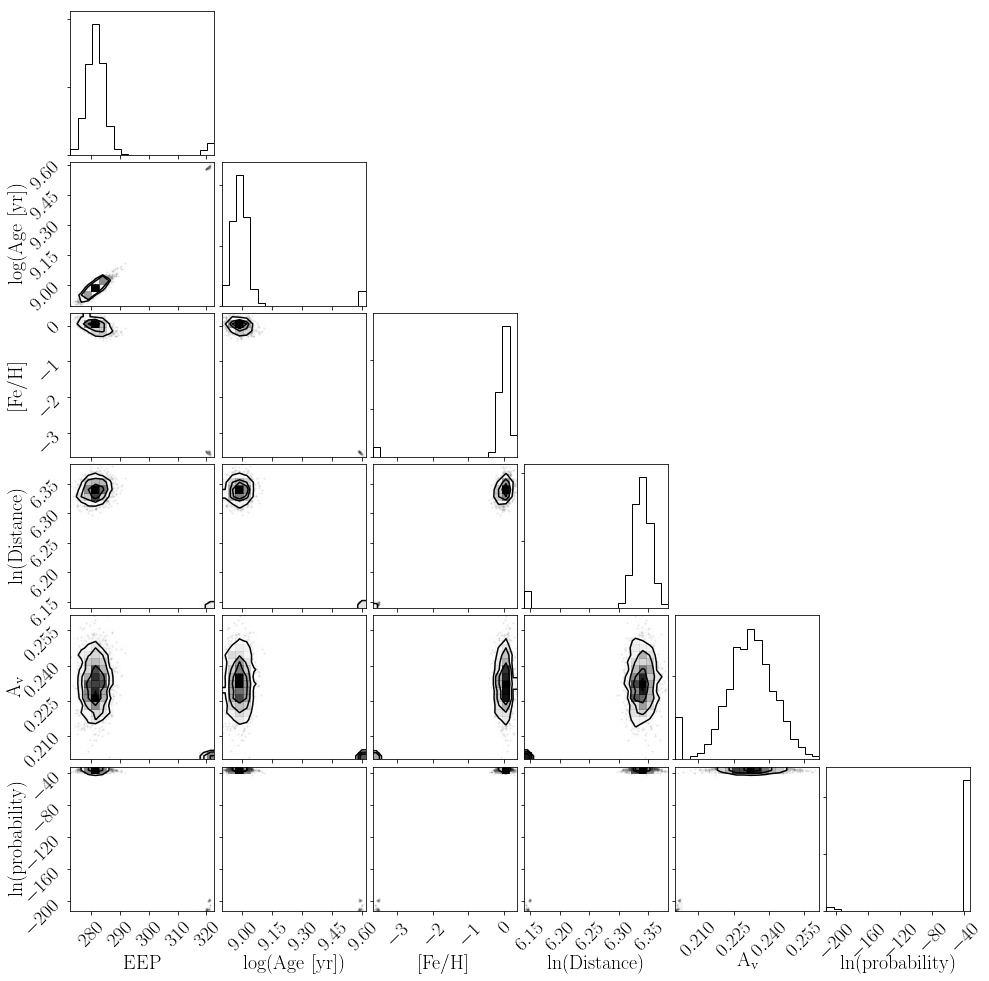

In [38]:
import corner

plotpar = {'axes.labelsize': 20,
           'xtick.labelsize': 20,
           'ytick.labelsize': 20}
plt.rcParams.update(plotpar)

labels = ["$\mathrm{EEP}$", "$\mathrm{log(Age~[yr])}$", 
          "$\mathrm{[Fe/H]}$", "$\mathrm{ln(Distance)}$",
          "$\mathrm{A_v}$", "$\mathrm{ln(probability)}$"]

corner.corner(flatsamples, labels=labels);